In [1]:
import sys
print(sys.executable)

/opt/miniconda3/bin/python


Original trace size: (256, 256), Padded trace size: (1468, 1468)
Running PCGP algorithm...
Iteration 0, Error: 0.293503
Iteration 10, Error: 0.000000
Temporal FWHM: 153.00 fs


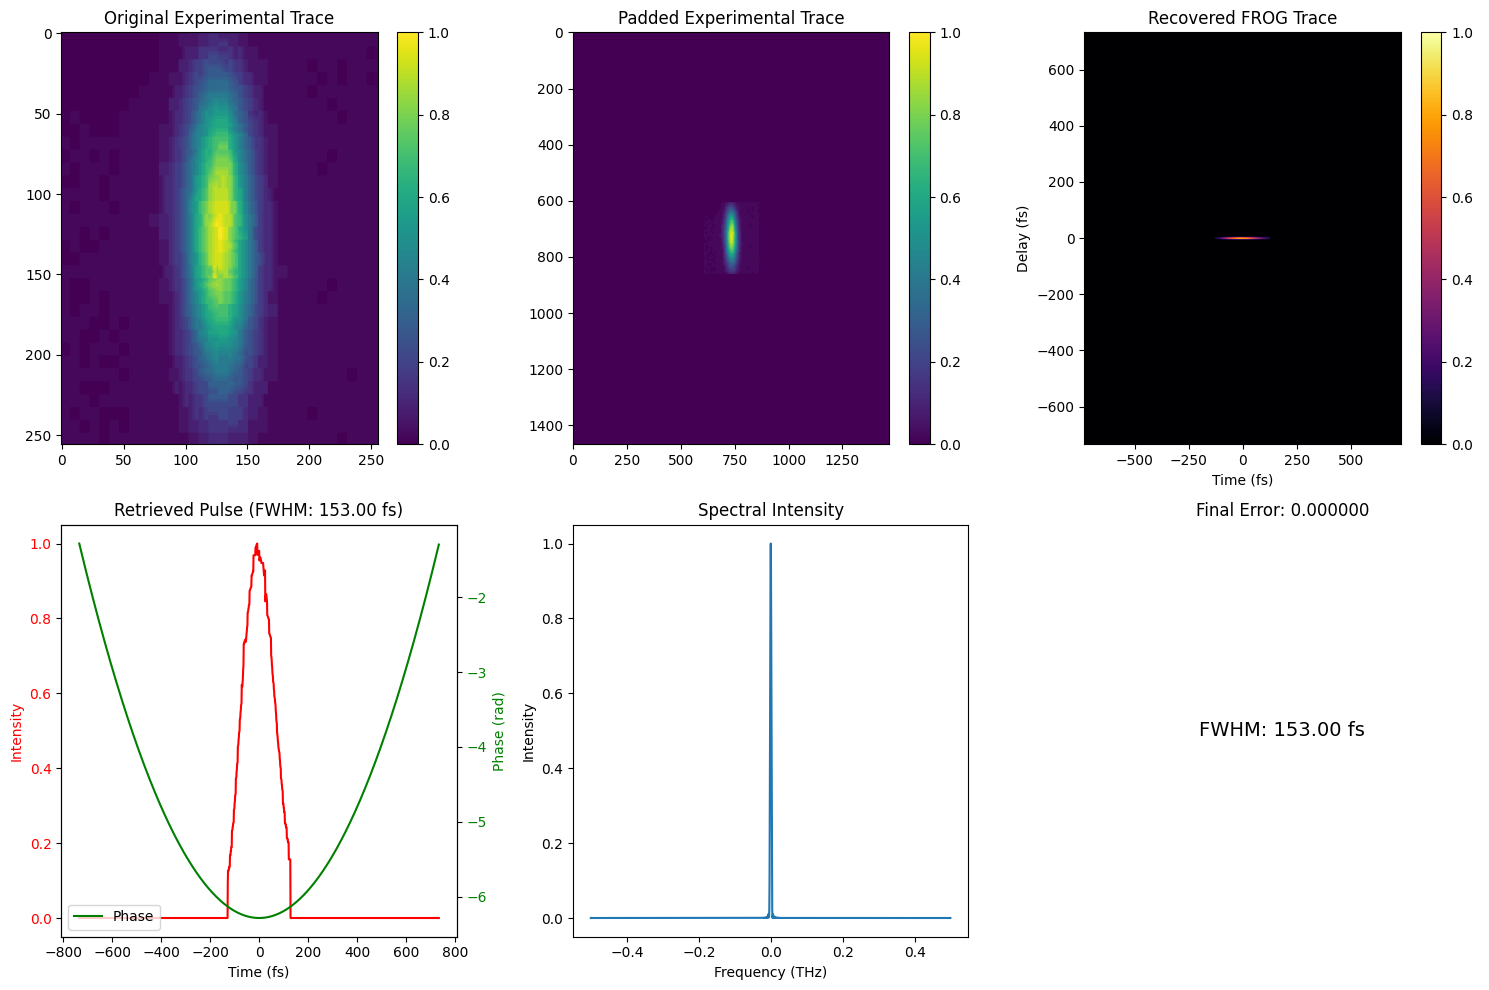

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from frog import PCGPAlgorithm, padded_trace, calculate_fwhm, VanillaFROG

# 1. Load your preprocessed FROG trace
exp_trace = np.loadtxt('preprocessed trace.txt')
exp_trace = exp_trace - 52
exp_trace = exp_trace / np.max(exp_trace)  # Normalize the trace
exp_trace[exp_trace < 0] = 0  # Set negative values to zero
# 2. Determine desired grid size (must be power of 2 for better FFT performance)
desired_size = 256  # Example: 256x256 grid
# Or you can use a calibration factor as in your original code
calibration = 5.734
desired_size = int(256 * calibration)
desired_size = int(np.round(desired_size/2) * 2)  # Make it even number

# 3. Pad the trace if necessary
current_size = exp_trace.shape[0]
if current_size < desired_size:
    pad_amount = desired_size - current_size
    padded_exp_trace = padded_trace(exp_trace, pad_amount, pad_amount)
else:
    padded_exp_trace = exp_trace

print(f"Original trace size: {exp_trace.shape}, Padded trace size: {padded_exp_trace.shape}")

# 4. Create PCGP instance
pcgp = PCGPAlgorithm()

# 5. Set up your time axis and initial pulse
N = padded_exp_trace.shape[0]
t = np.linspace(-N//2, N//2-1, N)  # Time axis

# Create an initial guess - Gaussian pulse with slight chirp
initial_pulse = np.exp(-t**2/(N/10)**2).astype(np.complex128)
initial_pulse *= np.exp(1j * 0.2 * t**2/(N/10)**2)

# 6. Run the PCGP algorithm
print("Running PCGP algorithm...")
recovered_pulse, recovered_trace, t, error = pcgp.retrieve_pulse(
    initial_pulse,
    padded_exp_trace,  # Transpose if needed for correct orientation
    max_iter=20,
    tolerance=1e-8
)

# 7. Normalize the recovered trace for display
recovered_trace = recovered_trace / np.max(recovered_trace)

# 8. Analyze results
# Calculate temporal FWHM
temporal_intensity = np.abs(recovered_pulse)**2
temporal_fwhm = calculate_fwhm(t, temporal_intensity)
print(f"Temporal FWHM: {temporal_fwhm:.2f} fs")

# Calculate spectral properties
spectrum = np.fft.fftshift(np.fft.fft(np.fft.ifftshift(recovered_pulse)))
spectral_intensity = np.abs(spectrum)**2 / np.max(np.abs(spectrum)**2)

# 9. Plot results
plt.figure(figsize=(15, 10))

# Original vs padded trace
plt.subplot(231)
plt.title("Original Experimental Trace")
plt.imshow(exp_trace, aspect='auto', cmap='viridis')
plt.colorbar()

plt.subplot(232)
plt.title("Padded Experimental Trace")
plt.imshow(padded_exp_trace, aspect='auto', cmap='viridis')
plt.colorbar()

plt.subplot(233)
plt.title("Recovered FROG Trace")
plt.imshow(recovered_trace.T, aspect='auto', cmap='inferno',
           extent=[t[0], t[-1], t[0], t[-1]])
plt.colorbar()
plt.xlabel("Time (fs)")
plt.ylabel("Delay (fs)")

# Temporal profile
plt.subplot(234)
plt.title(f"Retrieved Pulse (FWHM: {temporal_fwhm:.2f} fs)")

# Intensity (left y-axis)
ax1 = plt.gca()
ax1.plot(t, temporal_intensity/np.max(temporal_intensity), 'r-', label='Intensity')
ax1.set_xlabel("Time (fs)")
ax1.set_ylabel("Intensity", color='r')
ax1.tick_params(axis='y', labelcolor='r')

# Phase (right y-axis)
ax2 = ax1.twinx()
ax2.plot(t, np.unwrap(np.angle(recovered_pulse)), 'g-', label='Phase')
ax2.set_ylabel("Phase (rad)", color='g')
ax2.tick_params(axis='y', labelcolor='g')

plt.legend()

# Spectral profile
plt.subplot(235)
plt.title("Spectral Intensity")
freq_axis = np.fft.fftshift(np.fft.fftfreq(N, t[1]-t[0]))
plt.plot(freq_axis, spectral_intensity)
plt.xlabel("Frequency (THz)")
plt.ylabel("Intensity")

# Error plot - if you want to track errors
plt.subplot(236)
plt.title(f"Final Error: {error:.6f}")
plt.text(0.5, 0.5, f"FWHM: {temporal_fwhm:.2f} fs", 
         horizontalalignment='center', verticalalignment='center',
         transform=plt.gca().transAxes, fontsize=14)
plt.axis('off')

plt.tight_layout()
plt.show()

# # 10. Save results if desired
# np.savetxt('recovered_pulse.txt', 
#            np.column_stack((t, np.abs(recovered_pulse), np.angle(recovered_pulse))))

Iteration 0, FROG error: 0.025706


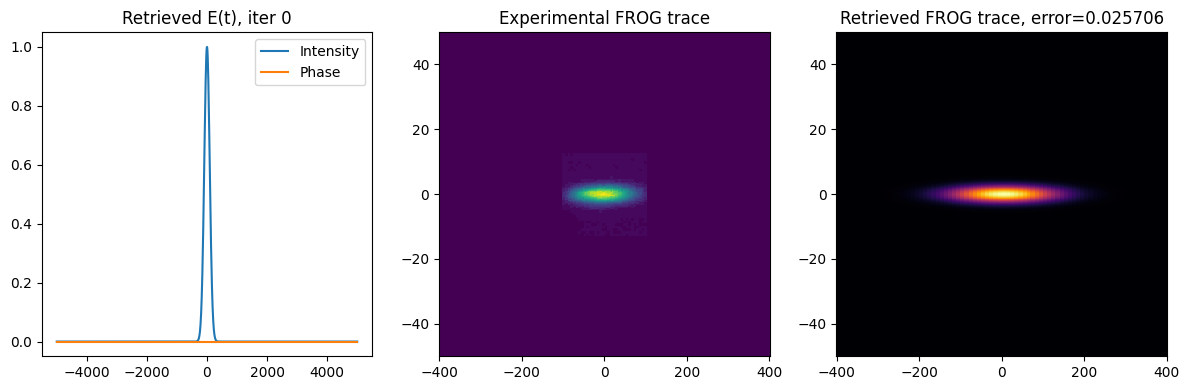

Iteration 20, FROG error: 0.018191


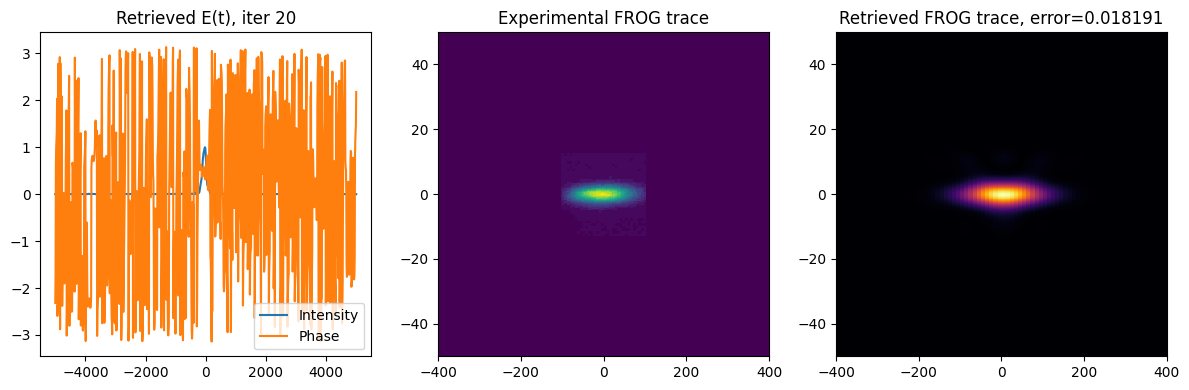

Iteration 40, FROG error: 0.018389


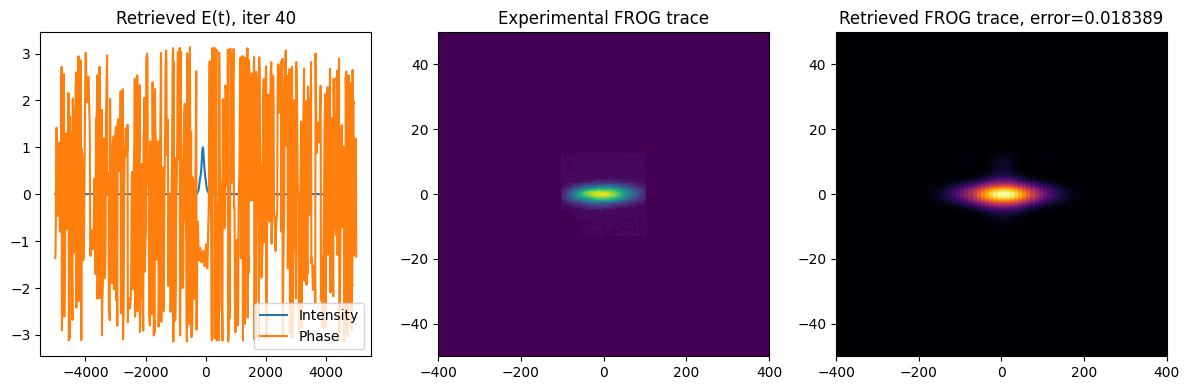

Iteration 60, FROG error: 0.018252


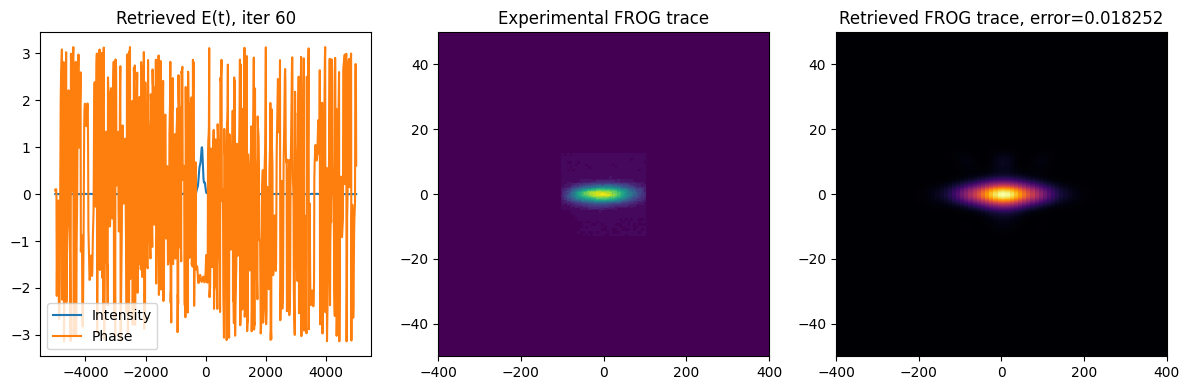

Iteration 80, FROG error: 0.018188


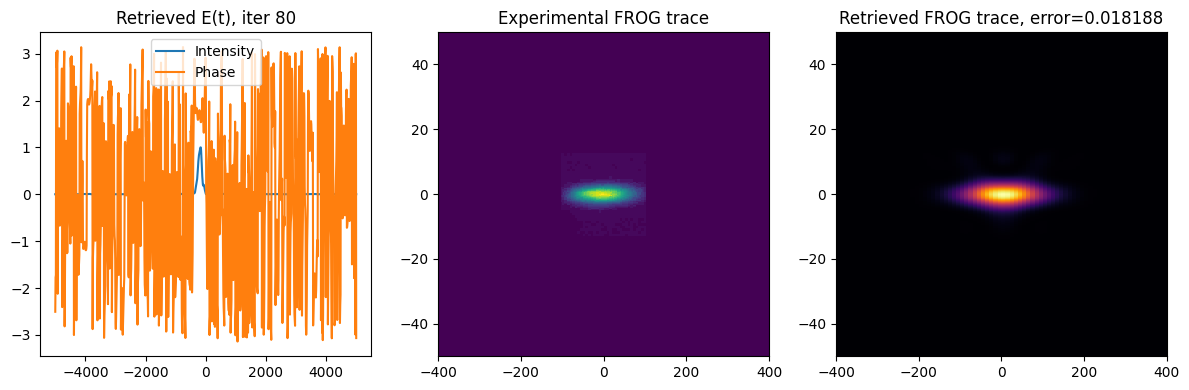

Final FROG error after 100 iterations: 0.018348


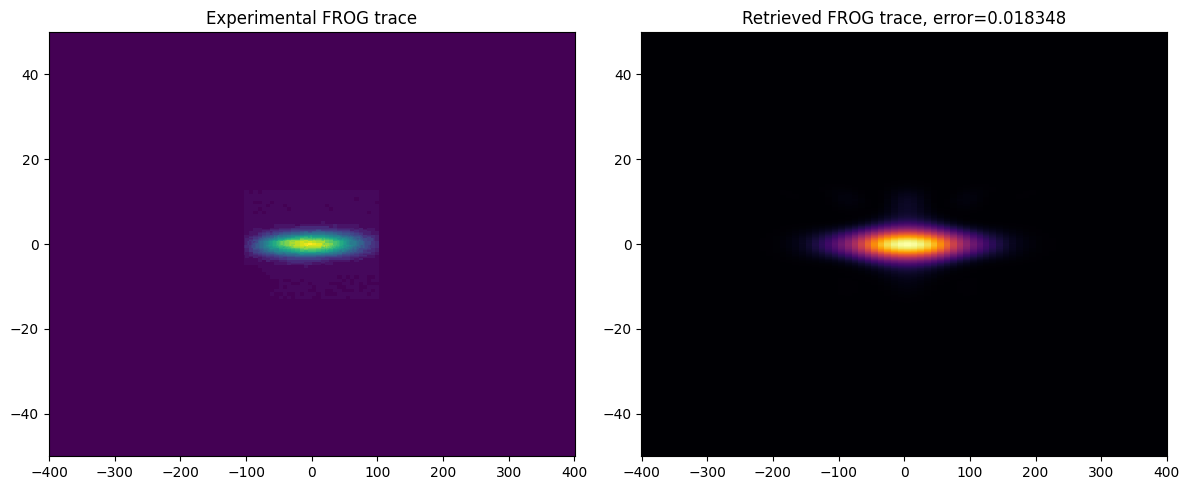

In [20]:
# Initialize vanilla FROG
vanilla = VanillaFROG()

# Create computational grid
time, taus, freq, dt = vanilla.grid(1000, 1000, 5000)  # Adjust parameters as needed

# Pad the trace if necessary
if exp_trace.shape[0] < 1000:
    pad_size = 1000 - exp_trace.shape[0]
    padded_exp_trace = padded_trace(exp_trace, pad_size, pad_size)
else:
    padded_exp_trace = exp_trace

# Initial pulse guess (simple Gaussian)
pulse = np.exp(-2*np.log(2) * (time/150)**2)  # 150 fs FWHM initial guess
initial_pulse = pulse

# Run the algorithm
retrieved_pulse, error_history = vanilla.retrieve_pulse(
    initial_pulse,
    padded_exp_trace,
    taus,
    time,
    freq,
    iterations=100,
    plot_every=20  # Show progress every 20 iterations
)

# Analyze and plot results as with PCGP